### This file contains examples from Part 2 of the QuantEcon Julia Tutorial

Simulating Markov Chains with QuantEcon package.  

In [1]:
using QuantEcon
P=[0.4 0.6; 0.2 0.8] # transition matrix
mc=MarkovChain(P)
x=simulate(mc,100000)
mean(x.==1)

0.25006

Exercise 1: Simple Application of the Kalman filter.  
* all variables scalar  
* hidden state $\{x_t\}$ is a constant
* Dynamics: $A=1, Q=0, x_0=\theta$, where $\theta$ is the true value of the hidden state
* measurement equation: $y_t=\theta + \nu_t$ where $\nu_t$ is $N(0,1)$ and iid
* Simulate the model and plot first five predictive densities $p_t(x)=N(\hat{x}_t,\Sigma_t)$
* $\theta=10, \hat{x}_0=8, \Sigma_0=1$

In [2]:
A=1.0
Q=0.0
G=1.0
R=1.0
theta=10
xhat=8.0
sigma0=1.0
x0=theta
# initialize the Kalman filter
kalman=Kalman(A,G,Q,R)
# set the initial state
set_state!(kalman,xhat,sigma0)

Void


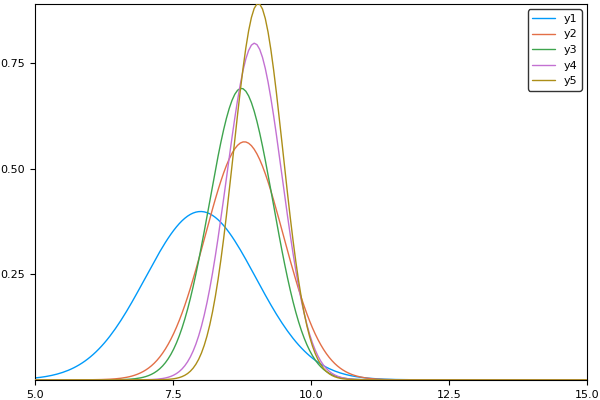

In [3]:
using Distributions
using Plots
# Run update of kalman filter for five runs
N=5
# define grid for x (built around the true value x0=theta)
densities=[]
labels=[]
xgrid=linspace(theta-5,theta+5,200)

for i=1:N
   mean, var=kalman.cur_x_hat, kalman.cur_sigma # this is the current mean and variance
    # plot this
    push!(densities, pdf(Normal(mean, sqrt(var)), xgrid))


    # Generate the noisy signal
    y = theta + randn()

    # Update the Kalman filter
    update!(kalman, y)
end

plot(xgrid, densities, grid=false)


## Single-Agent Models

Exercise 1: Working on the McCall Model 

In [4]:
using Distributions
# define utility function and distributions
function utility(c,sigma)
    if c>0
        out=(c^(1-sigma)-1)/(1-sigma)
    else
        out=-10e6 
    end
    return out
end
    
const n=60 # size of wage vector
const default_w_vec=linspace(10,20,n)
const a, b = 600, 400                          # shape parameters
const dist = BetaBinomial(n-1, a, b)
const default_p_vec = pdf(dist)

60-element Array{Float64,1}:
 3.67931e-23
 2.84383e-21
 1.08458e-19
 2.72048e-18
 5.04754e-17
 7.38675e-16
 8.87878e-15
 9.01291e-14
 7.8848e-13 
 6.03684e-12
 4.09402e-11
 2.48316e-10
 1.35769e-9 
 ⋮          
 0.000352228
 0.000124972
 3.96609e-5 
 1.11503e-5 
 2.74386e-6 
 5.81976e-7 
 1.04261e-7 
 1.53435e-8 
 1.78128e-9 
 1.52988e-10
 8.64331e-12
 2.40987e-13

In [5]:
# create a type called McCall Model (so we can use it multiple times)
type McCall
    alpha::Float64        # Job separation rate
    beta::Float64         # Discount rate
    gammaparam::Float64        # Job offer rate
    c::Float64            # Unemployment compensation
    sigma::Float64        # Utility parameter
    w_vec::Vector{Float64} # Possible wage values
    p_vec::Vector{Float64} # Probabilities over w_vec
    
    # define a function that returns a new instance of this type
    function McCall(alpha=0.2,beta=0.98,gammaparam=0.7,c=6.0,sigma=2.0, w_vec=default_w_vec, p_vec=default_p_vec)
        return new(alpha, beta, gammaparam, c, sigma, w_vec, p_vec) # this new function creates a new instance of the type
    end
end

In [ ]:
# write a function to update the bellman equation 
# we write update_V! (with an exclamation mark because the value of V_new in the argument is going to be modified in place)

In [6]:
function update_bellman!(mcm,V,V_new,U) # V_new is modified, and mcm is an instance of the mccall model
    # Simplify notation
    alpha, beta, sigma, c, gammaparam = mcm.alpha, mcm.beta, mcm.sigma, mcm.c, mcm.gammaparam
    for (ind_w,w) in enumerate(mcm.w_vec)
        V_new[ind_w]=utility(w,sigma)+beta*((1-alpha)*V[ind_w]+alpha*U)      
    end
    U_new = utility(c, sigma) + beta * (1 - gammaparam) * U +
                    beta * gammaparam * sum(max(U, V) .* mcm.p_vec)

    return U_new
end

update_bellman! (generic function with 1 method)

In [7]:
# write a function for solving the model
function solve_mccall(mcm::McCall;tol::Float64=1e-5,maxiter::Int=100 )
    V=ones(length(mcm.w_vec))
    V_new=similar(V) # similar creates an array just like V
    err=tol+1 
    U=1.0
    i=0
    while i<maxiter
        U_new = update_bellman!(mcm, V, V_new, U)
        error_1 = maximum(abs(V_new - V))
        error_2 = abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1
    end

    return V, U
end

solve_mccall (generic function with 1 method)

In [8]:
# solve an instance of the McCall model
mcm=McCall()
V,U=solve_mccall(mcm)


([39.6361,39.6438,39.6513,39.6585,39.6655,39.6723,39.6788,39.6852,39.6914,39.6974  …  39.8485,39.8508,39.853,39.8552,39.8573,39.8595,39.8616,39.8636,39.8656,39.8676],39.693865261373396)


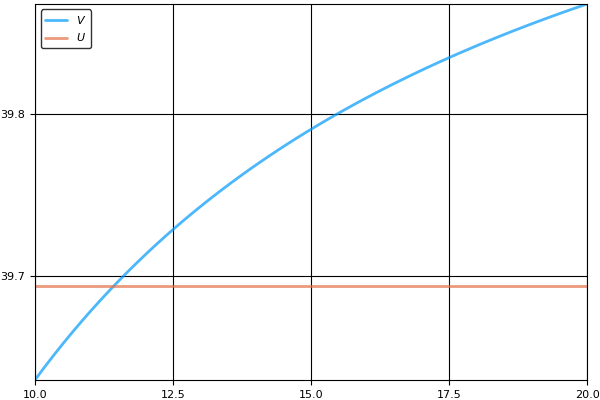

In [9]:
using LaTeXStrings
using Plots
U_vec = U .* ones(length(mcm.w_vec))

plot(mcm.w_vec, 
        [V U_vec],
        lw=2, 
        alpha=0.7, 
        label=[L"$V$" L"$U$"])


### Exercise 2: Stochastic Growth Model

Use Value Function Iteration to compute the solution to a stochastic growth model with piecewise linear interpolation.

In [ ]:
# import packages
using QuantEcon
using Optim

#= Arguments
w: array with values of guess for value function
grid: array with values for y
u: function for calculating utility
f: function for calculating production
shocks: array with production shocks 
beta: discount factor scalar
Tw: array with values for update of value function
compute_policy: boolean, optional
=# 

function bellman_operator(w::Array{Float64}, grid::Array{Float64},beta::Float64,u,f,shocks::Array{Float64}; compute_policy="False")
    # QuantEcon's LinInterp(x,y) takes the grid points x and the function points at x, y
    w_func=LinInterp(grid,w)
    # w_func is now a function that takes a value in between gridpoints and 
    # gives the interpolated value
    
    # Tw has the same shape as w
    Tw=similar(w)
    c_star=similar(w)
    
    # set Tw[i]=max_c {u(c)+ beta E w(f(y-c)z)}
    # y is the state
    for (i,y) in enumerate(grid)
        # define anonymous function to do maximization
        objective(c)=(-1.0)*(u(c)+beta*mean(w_func.(f(y-c).*shocks)))
        
        opt_choice=optimize(objective, 1e-10,y)
        Tw[i]=-opt_choice.minimum
        c_star[i]=opt_choice.minimizer
    end
    
    if compute_policy==false
        return Tw
    else 
        return Tw,c_star
    end
end

In [ ]:
# this illustrates how the mean() function works
shocks=exp(0.1*randn(250))
z=mean(shocks) # uses Monte-Carlo integration

In [ ]:
# set-up the utility and production function
alpha=0.4
beta=0.96
mu=0
s=0.1

u(c)=log(c)
f(k)=k^alpha

grid_max=4
grid_size=200
shock_size=250

grid_y=collect(linspace(1e-5,grid_max,grid_size))
shocks=exp(mu+s*randn(shock_size))

# iterating on the Bellman Operator
w=5*log(grid_y) # initial guess
n=35 # of iterations
# set-up plots
using PyPlot
fig, ax=subplots(figsize=(9,6))
# set y axis limits
ax[:set_ylim](-50,10)
# set x axis limits
#=ax[:set_xlim](minimum(grid_y),maximum(grid_y))
lb="initial condition"
jet=ColorMap("jet")
for i in 1:n
    w = bellman_operator(w,
                         grid_y,
                         beta,
                         log,
                         k -> k^alpha,
                         shocks)

    ax[:plot](grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

show()=#


In [ ]:
# now use the QuantEcon.compute_fixed_point method to calculate the value function
bellman_operator(w)=bellman_operator(w,grid_y,beta,log,k->k^alpha,shocks)
initial_w=5*log(grid_y)
vstar=compute_fixed_point(bellman_operator,initial_w,max_iter=500)

In [ ]:
# plot the results
fig,ax=subplots(figsize=(9,5)) # define the subplot size
ax[:set_ylim](-35,-24)
ax[:plot](grid_y,vstar,lw=2)
show()


In [ ]:
# compute the policy function 
v_star,c_star=bellman_operator(vstar,grid_y,beta,log,k -> k^alpha,shocks;compute_policy=true)
fig,ax=subplots(figsize=(9,5))
ax[:plot](grid_y,c_star,lw=2,alpha=0.6)
show()

#### Exercise: Once an optimal consumption policy is given, we can plot the dynamics for the capital stock from simulations

In [ ]:
# initial condition is y0=0.1
# do it for a sequence of three discount factors (0.9,0.94,0.98)

function simulate_capital(grid_y::Array{Float64},beta::Float64,shocks)
    # now use the QuantEcon.compute_fixed_point method to calculate the value function
    bellman_operator1(w)=bellman_operator(w,grid_y,beta,log,k->k^alpha,shocks)
    initial_w=5*log(grid_y)
    vstar=compute_fixed_point(bellman_operator1,initial_w,max_iter=500)
    vstar,cstar=bellman_operator(vstar,grid_y,beta,log,k->k^alpha,shocks;compute_policy=true)
    cfunc=LinInterp(grid_y,cstar)
    T=100
    ypath=zeros(T,1)
    kpath=similar(ypath1)
    ypath[1]=y0
    shocks=exp(0.1*randn(T))
    for i=2:T
        c=cfunc(ypath[i-1])
        kpath[i]=ypath[i-1]-c
        ypath[i]=(kpath[i]^alpha)*shocks[i]
    end
    
    return kpath
    
end


In [ ]:
beta1=0.9
beta2=0.94
beta3=0.98
shocks=exp(mu+s*randn(100))
kpath1=simulate_capital(grid_y,0.9,shocks)
kpath2=simulate_capital(grid_y,0.94,shocks)
kpath3=simulate_capital(grid_y,0.98,shocks)

In [ ]:
bellman_operator1(w)=bellman_operator(w,grid_y,beta,log,k->k^alpha,shocks)
    initial_w=5*log(grid_y)
    vstar=compute_fixed_point(bellman_operator1,initial_w,max_iter=500)
    vstar,cstar=bellman_operator(vstar,grid_y,beta,log,k->k^alpha,shocks;compute_policy=true)
    cfunc=LinInterp(grid_y,cstar)
    T=100
    ypath=zeros(T,1)
    kpath=similar(ypath1)
    ypath[1]=y0
    shocks=exp(0.1*randn(T))
    for i=2:T
        c=cfunc(ypath[i-1])
        kpath[i]=ypath[i-1]-c
        ypath[i]=(kpath[i]^alpha)*shocks[i]
    end